#Credit Card Default Prediction


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 Data Loading

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Finance dataset/train_dataset_final1.csv")

In [5]:
print(df.head())
print(df.info())
print(df.describe())

   Customer_ID  marriage  sex  education  LIMIT_BAL   age  pay_0  pay_2  \
0         5017         2    0          2      60000  25.0      2      2   
1         5018         2    1          1     290000  24.0      0      0   
2         5019         1    0          2     180000  63.0      0      0   
3         5020         1    1          2     210000  43.0      0      0   
4         5021         2    0          1     280000  32.0     -2     -2   

   pay_3  pay_4  ...  Bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  \
0      2      0  ...   20750.63   2000.21      0.00   1134.85   1821.78   
1     -2     -2  ...    1350.30      0.00      0.17      0.00   2700.10   
2      0      0  ...   52991.51   2086.94   2199.99   1845.66   2000.35   
3      0      0  ...   76945.47   3348.07   3380.91   3400.45   2683.97   
4     -2     -2  ...       1.35    999.78   3186.27  45027.78   2100.09   

   pay_amt5  pay_amt6  AVG_Bill_amt  PAY_TO_BILL_ratio  next_month_default  
0   1500.03   1500.24

Handling Missing Values (if any)

In [6]:
print(df.isnull().sum())

Customer_ID             0
marriage                0
sex                     0
education               0
LIMIT_BAL               0
age                   126
pay_0                   0
pay_2                   0
pay_3                   0
pay_4                   0
pay_5                   0
pay_6                   0
Bill_amt1               0
Bill_amt2               0
Bill_amt3               0
Bill_amt4               0
Bill_amt5               0
Bill_amt6               0
pay_amt1                0
pay_amt2                0
pay_amt3                0
pay_amt4                0
pay_amt5                0
pay_amt6                0
AVG_Bill_amt            0
PAY_TO_BILL_ratio       0
next_month_default      0
dtype: int64


In [7]:
if df['age'].isnull().sum() > 0:
    df['age'].fillna(df['age'].median(), inplace=True)

In [8]:
df['next_month_default'].value_counts()

,count
next_month_default,
0,20440
1,4807


##Financial & Behavioral EDA

This section explores key behavioral and financial patterns that help explain default risk among credit card customers. We focus on trends in payment status, utilization, age, spending, and repayment habits.

Target variable distribution


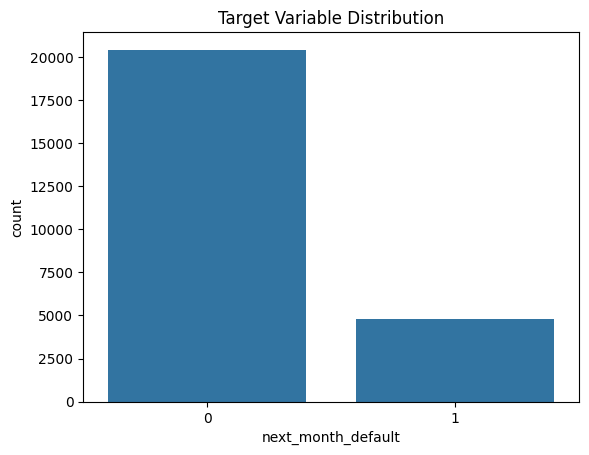

In [9]:
sns.countplot(x='next_month_default', data=df)
plt.title('Target Variable Distribution')
plt.show()


The percentage of defaulters in the data is 19.039885927040835 %


[]

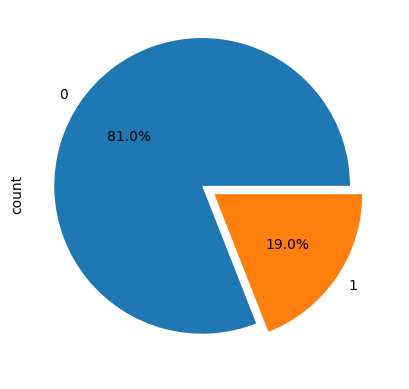

In [10]:
perc_default = df.next_month_default.sum() / len(df.next_month_default)
print(f'The percentage of defaulters in the data is {perc_default*100} %')
df['next_month_default'].value_counts().plot(kind='pie',explode=[0.1,0],autopct="%1.1f%%")
plt.plot()

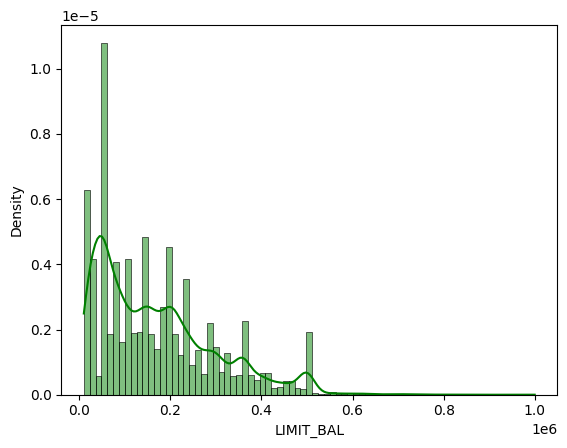

In [11]:
sns.histplot(df['LIMIT_BAL'], kde=True, stat="density", color='green')
plt.show()

In [12]:
gender_counts = df['sex'].value_counts()
gender_counts

,count
sex,
1,15252
0,9995


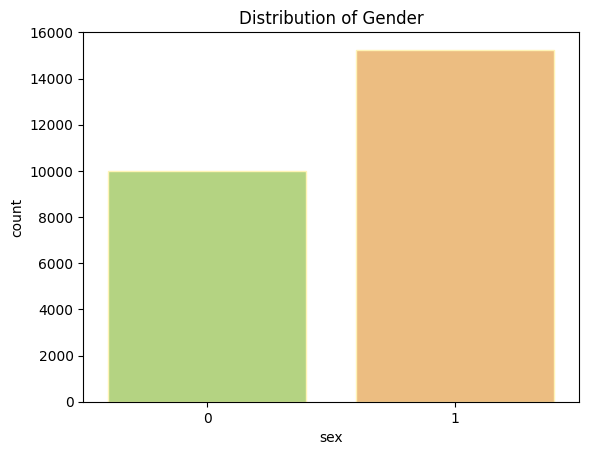

In [13]:
sns.countplot(x='sex', data=df,palette='RdYlGn_r', edgecolor=sns.color_palette("YlOrBr"))
plt.title('Distribution of Gender')
plt.show()

In [14]:
grouped_counts = df.groupby(['next_month_default','sex'])['sex'].count()
print(grouped_counts)

next_month_default  sex
0                   0       7910
                    1      12530
1                   0       2085
                    1       2722
Name: sex, dtype: int64


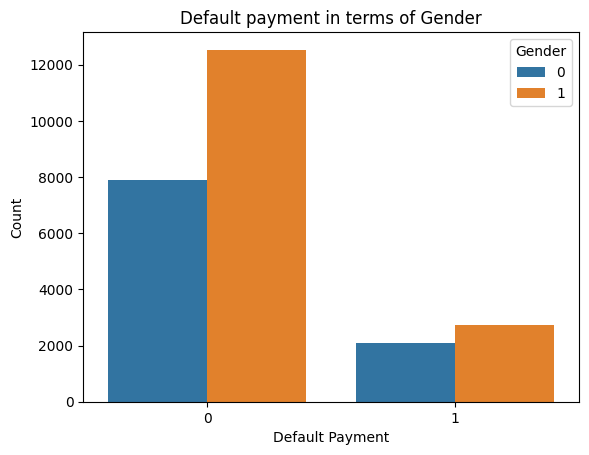

In [15]:

sns.countplot(x='next_month_default', hue='sex', data=df)


plt.title('Default payment in terms of Gender')
plt.xlabel('Default Payment')
plt.ylabel('Count')
plt.legend(title='Gender')


plt.show()

In [16]:
df['education'].value_counts()

,count
education,
2,11717
1,8988
3,4115
5,253
4,116
6,44
0,14


1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown

Assign unknown categories to other.

In [17]:
df['education'] = df['education'].replace(to_replace=[0, 5, 6], value=4)
df['education'].value_counts()

,count
education,
2,11717
1,8988
3,4115
4,427


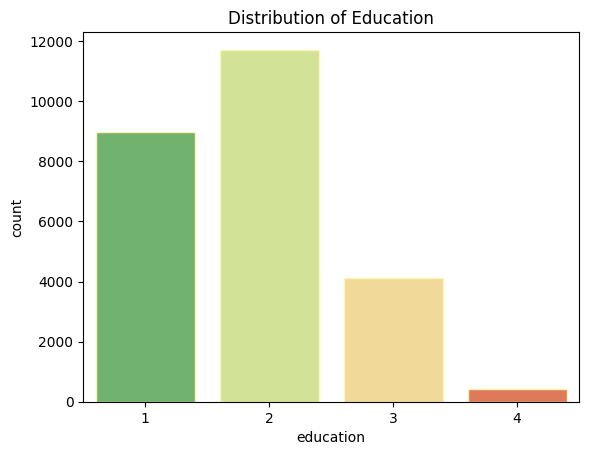

In [18]:
sns.countplot(x='education', data=df,palette='RdYlGn_r', edgecolor=sns.color_palette("YlOrBr"))
plt.title('Distribution of Education')
plt.show()

In [19]:
grouped_counts = df.groupby(['next_month_default','education'])['education'].count()
print(grouped_counts)

next_month_default  education
0                   1            7534
                    2            9267
                    3            3238
                    4             401
1                   1            1454
                    2            2450
                    3             877
                    4              26
Name: education, dtype: int64


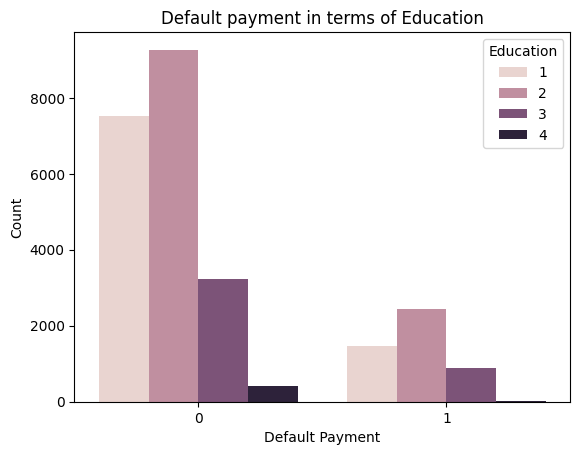

In [20]:
sns.countplot(x='next_month_default', hue='education', data=df)

plt.title('Default payment in terms of Education')
plt.xlabel('Default Payment')
plt.ylabel('Count')
plt.legend(title='Education')

plt.show()

In [21]:
df['marriage'].value_counts()

,count
marriage,
2,13441
1,11480
3,273
0,53


Marital status (1=married, 2=single, 3=others)

Assign unknown categories to other.

In [22]:
df['marriage'] = df['marriage'].replace(to_replace=[0], value=3)
df['marriage'].value_counts()

,count
marriage,
2,13441
1,11480
3,326


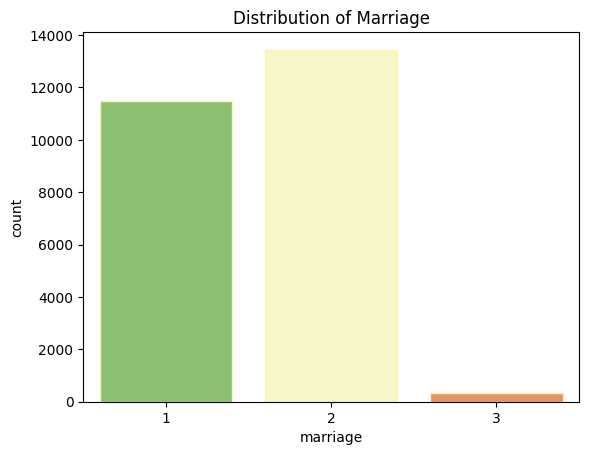

In [23]:
sns.countplot(x='marriage', data=df,palette='RdYlGn_r', edgecolor=sns.color_palette("YlOrBr"))
plt.title('Distribution of Marriage')
plt.show()

In [24]:
grouped_counts = df.groupby(['next_month_default','marriage'])['marriage'].count()
print(grouped_counts)

next_month_default  marriage
0                   1            9141
                    2           11037
                    3             262
1                   1            2339
                    2            2404
                    3              64
Name: marriage, dtype: int64


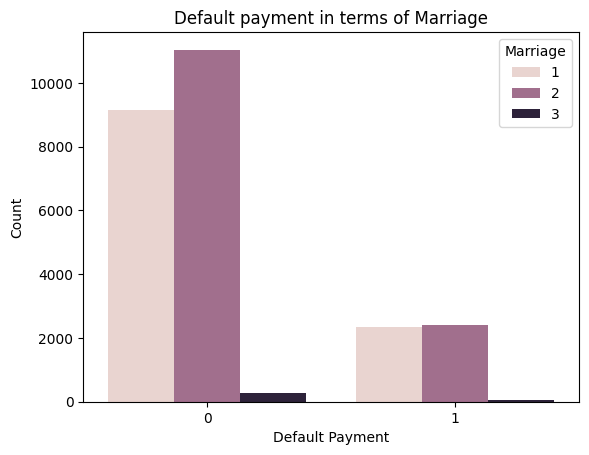

In [25]:
sns.countplot(x='next_month_default', hue='marriage', data=df)


plt.title('Default payment in terms of Marriage')
plt.xlabel('Default Payment')
plt.ylabel('Count')
plt.legend(title='Marriage')

plt.show()

### Correlation heatmap

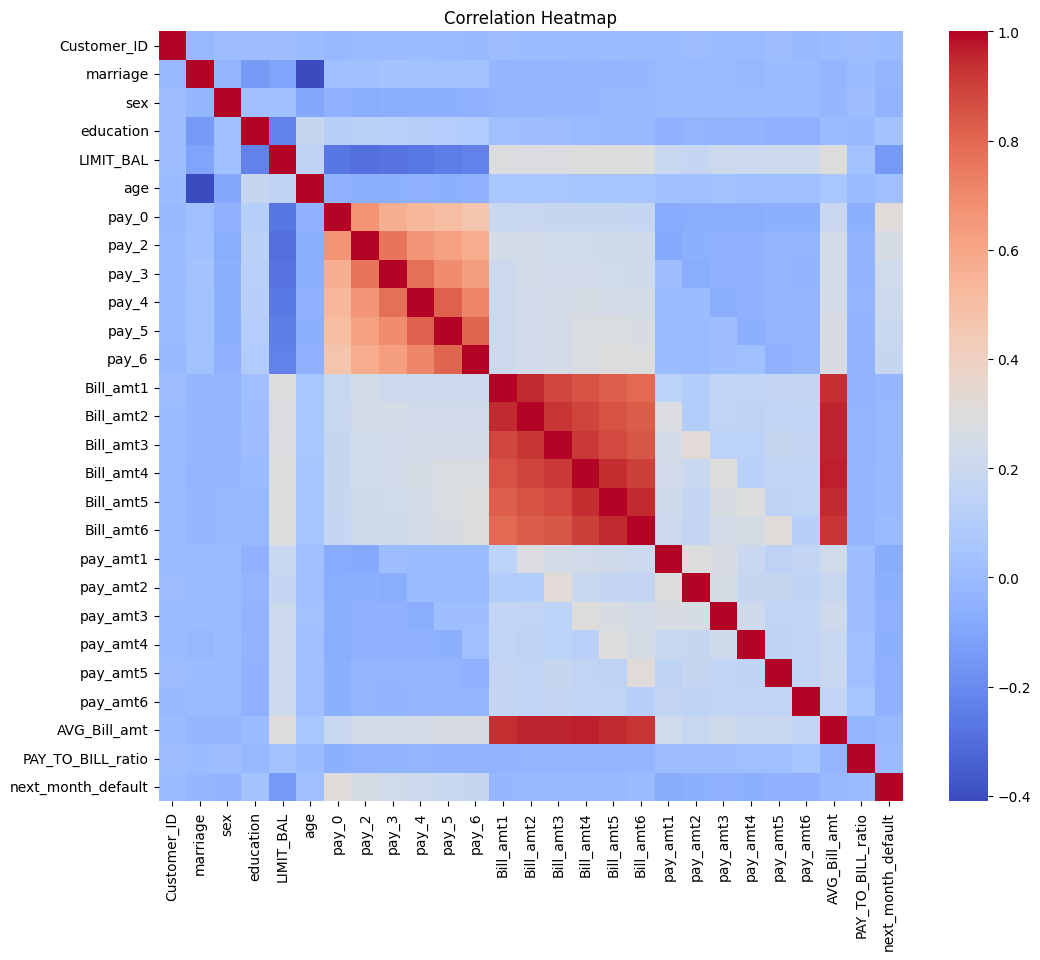

In [26]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

  payment behavior for Pay_0, Pay_2 to Pay_6

Customers with higher payment delays (PAY_0, PAY_2 to PAY_6 ≥ 1) are more likely to default. This indicates overdue payment behavior strongly contributes to default risk

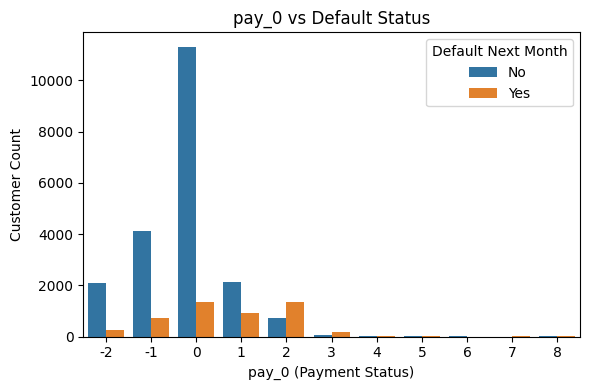

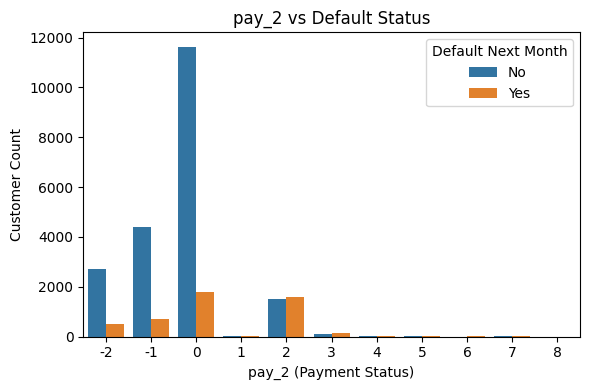

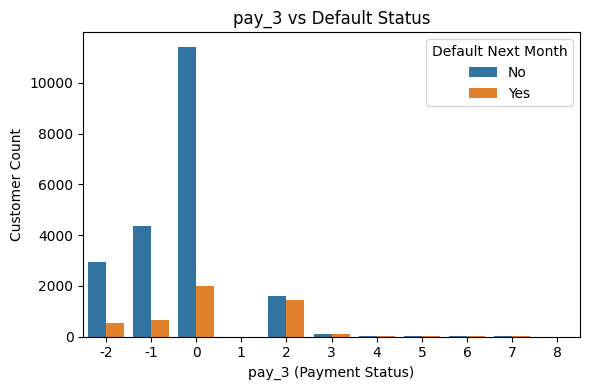

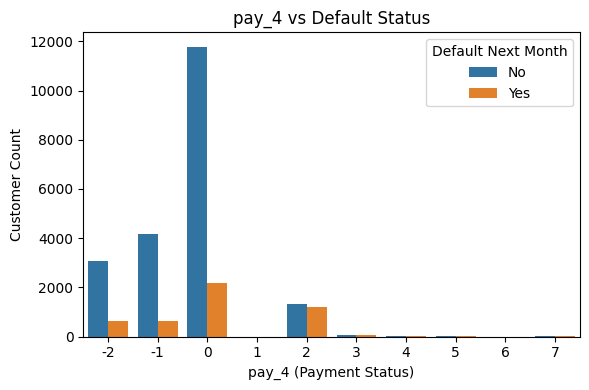

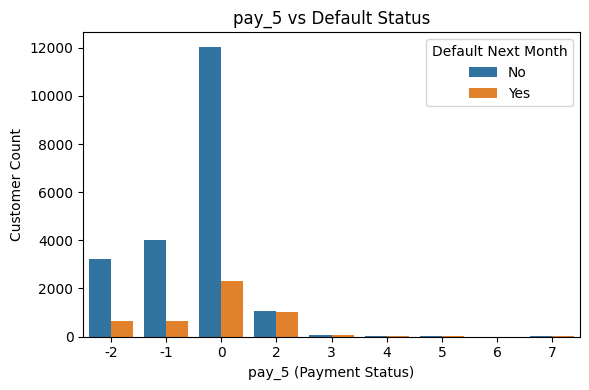

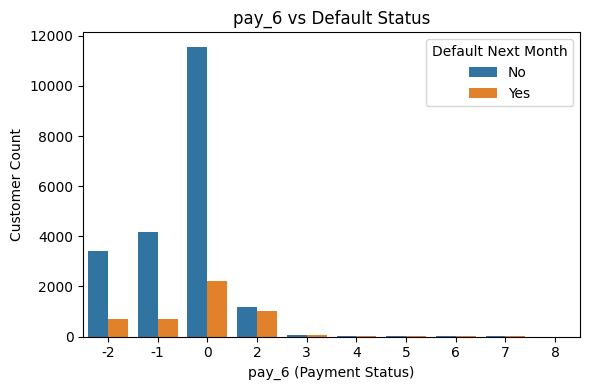

In [27]:
for i in [0, 2, 3, 4, 5, 6]:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=f'pay_{i}', hue='next_month_default', data=df)
    plt.title(f'pay_{i} vs Default Status')
    plt.xlabel(f'pay_{i} (Payment Status)')
    plt.ylabel('Customer Count')
    plt.legend(title='Default Next Month', labels=['No', 'Yes'])
    plt.tight_layout()
    plt.show()




###Credit Utilization
Defaulters tend to have higher credit utilization ratios, suggesting that customers who spend closer to their credit limit are at greater risk of missing payments

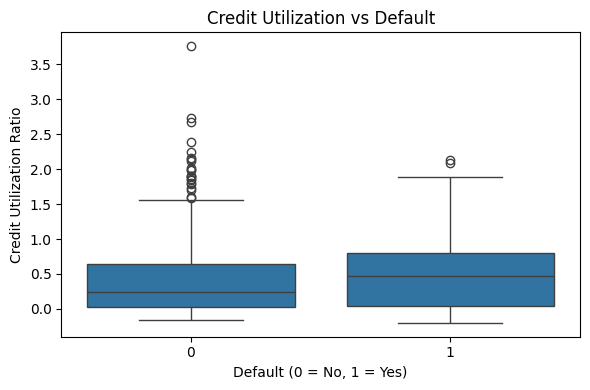

In [28]:
df['credit_utilization'] = df['AVG_Bill_amt'] / df['LIMIT_BAL']

plt.figure(figsize=(6, 4))
sns.boxplot(x='next_month_default', y='credit_utilization', data=df)
plt.title('Credit Utilization vs Default')
plt.xlabel('Default (0 = No, 1 = Yes)')
plt.ylabel('Credit Utilization Ratio')
plt.tight_layout()
plt.show()


###Age Group vs Default
The bar plot indicates that default rates increase with age. While younger age groups (20–40) show relatively lower default rates (~17–20%), older age groups, especially 60–80 years, exhibit significantly higher default rates, peaking at ~30%. This trend may reflect declining income stability or increasing financial burden with age.

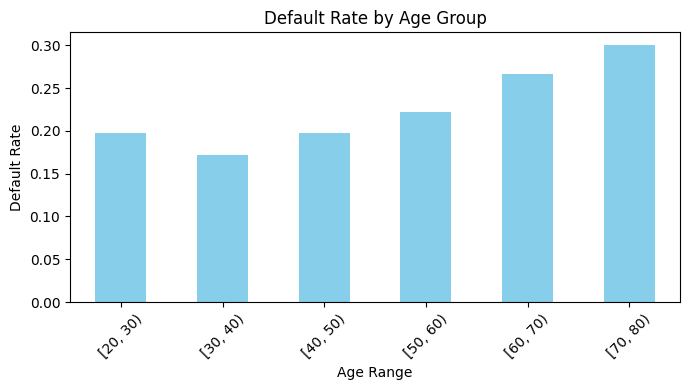

In [29]:

# Bin age into groups
df['age_bin'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 70, 80], right=False)

# Plot default rate by age group
age_default_rate = df.groupby('age_bin')['next_month_default'].mean()

plt.figure(figsize=(7, 4))
age_default_rate.plot(kind='bar', color='skyblue')
plt.title('Default Rate by Age Group')
plt.ylabel('Default Rate')
plt.xlabel('Age Range')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###Bill Amount Trends
Defaulting customers generally have slightly higher average monthly bill amounts, which may indicate over-leveraging or inability to manage debt.

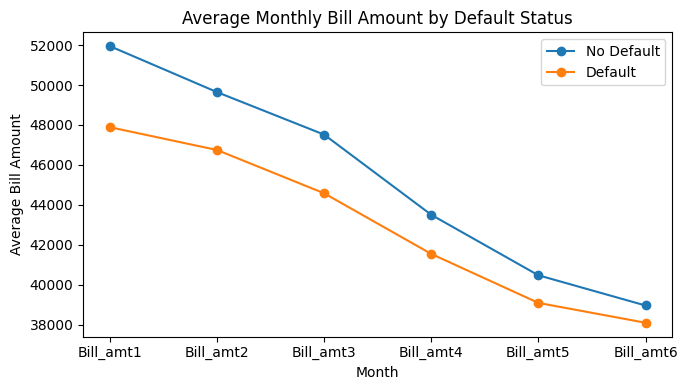

In [30]:
bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]

bill_df = df[bill_cols + ['next_month_default']].groupby('next_month_default').mean().T
bill_df.columns = ['No Default', 'Default']

bill_df.plot(figsize=(7, 4), marker='o')
plt.title('Average Monthly Bill Amount by Default Status')
plt.xlabel('Month')
plt.ylabel('Average Bill Amount')
plt.legend()
plt.tight_layout()
plt.show()


###Payment Consistency
Defaulters make lower and less consistent payments across months, highlighting irregular repayment habits and higher risk.

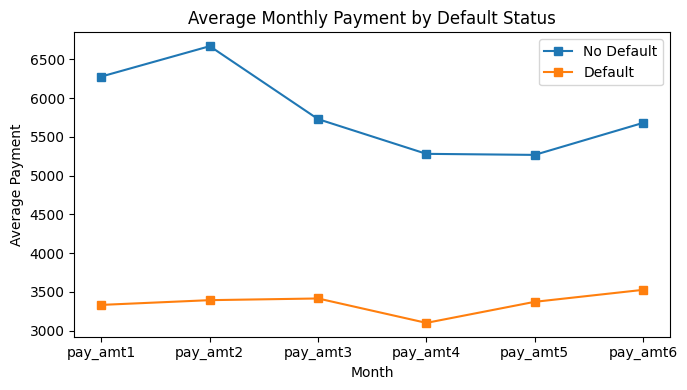

In [31]:
pay_cols = [f'pay_amt{i}' for i in range(1, 7)]

pay_df = df[pay_cols + ['next_month_default']].groupby('next_month_default').mean().T
pay_df.columns = ['No Default', 'Default']

pay_df.plot(figsize=(7, 4), marker='s')
plt.title('Average Monthly Payment by Default Status')
plt.xlabel('Month')
plt.ylabel('Average Payment')
plt.legend()
plt.tight_layout()
plt.show()


###Credit Limit vs Default
The bar chart reveals that default rates decrease as credit limit increases.

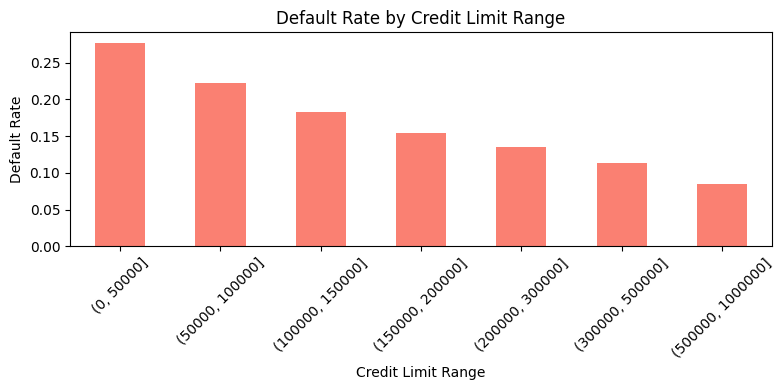

In [34]:
# Bin credit limits into ranges
df['Limit_bin'] = pd.cut(df['LIMIT_BAL'], bins=[0, 50000, 100000, 150000, 200000, 300000, 500000, 1000000])

limit_default_rate = df.groupby('Limit_bin')['next_month_default'].mean()

plt.figure(figsize=(8, 4))
limit_default_rate.plot(kind='bar', color='salmon')
plt.title('Default Rate by Credit Limit Range')
plt.ylabel('Default Rate')
plt.xlabel('Credit Limit Range')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [35]:
#Financial Insight
defaulters = df[df['next_month_default'] == 1]
non_defaulters = df[df['next_month_default'] == 0]

In [36]:
#Payment status analysis
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
df[pay_cols] = df[pay_cols].replace({-2: np.nan})

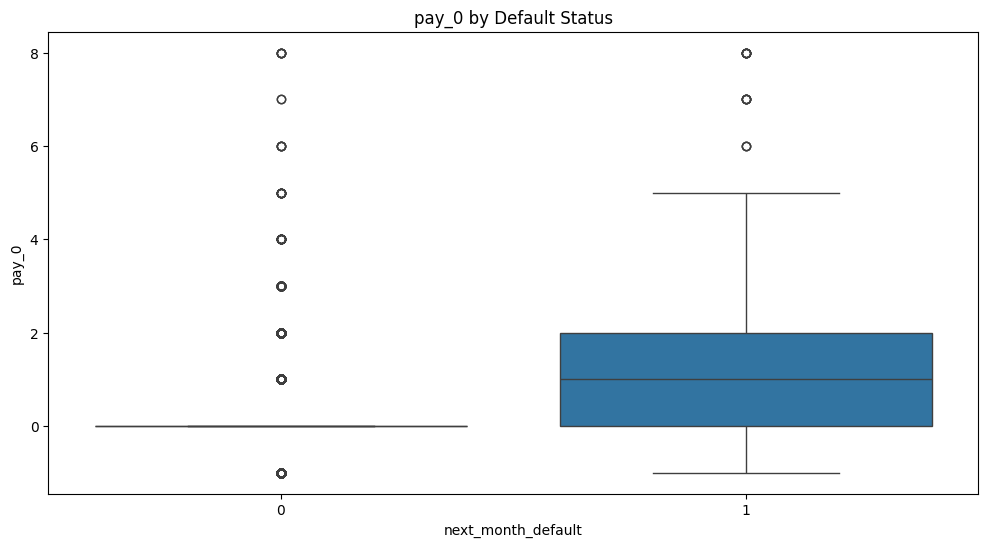

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='next_month_default', y='pay_0')
plt.title("pay_0 by Default Status")
plt.show()

In [38]:
print(df.columns.tolist())


['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'next_month_default', 'credit_utilization', 'age_bin', 'Limit_bin']


In [39]:
bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]
pay_cols = [f'pay_amt{i}' for i in range(1, 7)]
pay_status_cols = [f'pay_{i}' for i in [0, 2, 3, 4, 5, 6]]

##Feature Engineering

In [40]:
# Creating financial features
df['credit_utilization'] = df['AVG_Bill_amt'] / df['LIMIT_BAL']
df['total_bill_amt'] = df[bill_cols].sum(axis=1)
df['total_pay_amt'] = df[pay_cols].sum(axis=1)
df['payment_ratio'] = df['total_pay_amt'] / df['total_bill_amt'].replace(0, 1)
df['delinquency_streak'] = df[pay_status_cols].apply(lambda row: (row >= 1).sum(), axis=1)
df['payment_consistency'] = df[pay_cols].std(axis=1)
df['is_fully_paying'] = (df['delinquency_streak'] == 0).astype(int)

safe type casting

In [41]:
for col in ['sex', 'marriage', 'education']:
    df[col] = df[col].astype(int)

 Fill NaNs in numeric columns only

In [42]:
df[df.select_dtypes(include='number').columns] = df.select_dtypes(include='number').fillna(0)

Prepare features and target

Also removing Bins

In [43]:
X = df.drop(['Customer_ID', 'next_month_default', 'age_bin', 'Limit_bin'], axis=1)
y = df['next_month_default']

Initial Split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Handling Imabalance Data

In [45]:
# Applying SMOTE to training data only
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


In [46]:
feature_names = X_train.columns.tolist()


Scaling


In [47]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Spliting X_train again for model training vs model validation comparison

In [48]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)


In [49]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

In [52]:
def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    print(f"\n{name} Evaluation:")
    print(f"Accuracy:  {accuracy_score(y_val, preds):.4f}")
    print(f"Recall:    {recall_score(y_val, preds):.4f}")
    print(f"F1 Score:  {f1_score(y_val, preds):.4f}")
    print(f"F2 Score:  {fbeta_score(y_val, preds, beta=2):.4f}")
    return model


trained_models = {}
for name, model in models.items():
    trained_model = evaluate_model(name, model, X_train_split, y_train_split, X_val_split, y_val_split)
    trained_models[name] = trained_model



Logistic Regression Evaluation:
Accuracy:  0.7777
Recall:    0.7789
F1 Score:  0.7779
F2 Score:  0.7785

Decision Tree Evaluation:
Accuracy:  0.8120
Recall:    0.7419
F1 Score:  0.7978
F2 Score:  0.7633

Random Forest Evaluation:
Accuracy:  0.8907
Recall:    0.8514
F1 Score:  0.8862
F2 Score:  0.8650

XGBoost Evaluation:
Accuracy:  0.8838
Recall:    0.8382
F1 Score:  0.8782
F2 Score:  0.8538
[LightGBM] [Info] Number of positive: 13082, number of negative: 13081
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6903
[LightGBM] [Info] Number of data points in the train set: 26163, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500019 -> initscore=0.000076
[LightGBM] [Info] Start training from score 0.000076

LightGBM Evaluation:
Accuracy:  0.8791
Recall: 

##  Hyperparameter Tuning: GridSearchCV on Best Model (Random Forest)


In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score


f2_scorer = make_scorer(fbeta_score, beta=2)


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}


grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X_train_split, y_train_split)


best_model = grid_search.best_estimator_
print(" Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
 Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## Get feature importances from Random Forest

 Top 10 Important Features:
               Feature  Importance
31     is_fully_paying    0.108152
5                pay_0    0.104502
6                pay_2    0.063753
7                pay_3    0.044063
29  delinquency_streak    0.034802
8                pay_4    0.034450
10               pay_6    0.030430
9                pay_5    0.030103
25  credit_utilization    0.028882
17            pay_amt1    0.027961


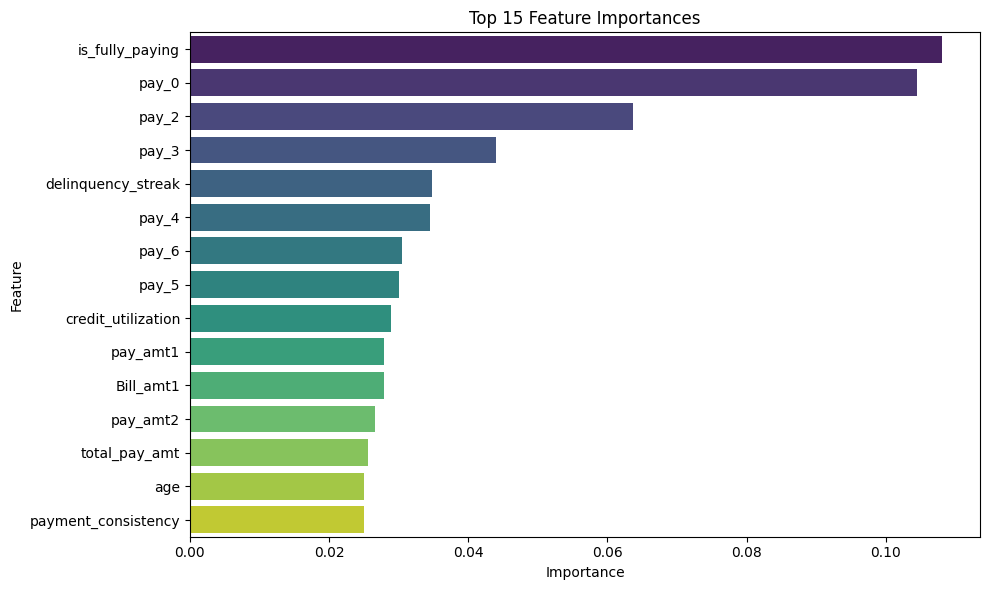

In [54]:
importances = best_model.feature_importances_


feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


print(" Top 10 Important Features:")
print(feature_importances.head(10))


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()


In [55]:
def find_best_f2_threshold(model, X_val, y_val):
    probs = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.1, 0.91, 0.01)
    scores = []

    for t in thresholds:
        preds = (probs >= t).astype(int)
        f2 = fbeta_score(y_val, preds, beta=2)
        scores.append((t, f2))

    best_thresh, best_f2 = max(scores, key=lambda x: x[1])
    print(f" Best Threshold: {best_thresh:.2f}, F2 Score: {best_f2:.4f}")
    return best_thresh


best_thresh = find_best_f2_threshold(best_model, X_val_split, y_val_split)


 Best Threshold: 0.30, F2 Score: 0.9033


 Predictions on validation split (not validation.csv)

In [56]:
val_preds = best_model.predict(X_val_split)

print(" Classification Report (Validation Split):")
print(classification_report(y_val_split, val_preds, digits=4))


 Classification Report (Validation Split):
              precision    recall  f1-score   support

           0     0.8650    0.9346    0.8985      3271
           1     0.9288    0.8541    0.8899      3270

    accuracy                         0.8944      6541
   macro avg     0.8969    0.8944    0.8942      6541
weighted avg     0.8969    0.8944    0.8942      6541



In [57]:
test_preds = best_model.predict(X_test)
print(" Classification Report (Test Set):")
print(classification_report(y_test, test_preds, digits=4))


 Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.8677    0.9388    0.9019      4088
           1     0.6013    0.3919    0.4745       962

    accuracy                         0.8347      5050
   macro avg     0.7345    0.6654    0.6882      5050
weighted avg     0.8170    0.8347    0.8205      5050



In [58]:
val_df = pd.read_csv("/content/drive/MyDrive/Finance dataset/validate_dataset_final.csv")

## Apply Feature Engineering (same as training)

In [59]:
bill_cols = [f'Bill_amt{i}' for i in range(1, 7)]
pay_cols = [f'pay_amt{i}' for i in range(1, 7)]
pay_status_cols = [f'pay_{i}' for i in [0, 2, 3, 4, 5, 6]]

# Create engineered features

In [60]:
val_df['AVG_Bill_amt'] = val_df[bill_cols].mean(axis=1)
val_df['credit_utilization'] = val_df['AVG_Bill_amt'] / val_df['LIMIT_BAL']
val_df['total_bill_amt'] = val_df[bill_cols].sum(axis=1)
val_df['total_pay_amt'] = val_df[pay_cols].sum(axis=1)
val_df['payment_ratio'] = val_df['total_pay_amt'] / val_df['total_bill_amt'].replace(0, 1)
val_df['delinquency_streak'] = val_df[pay_status_cols].apply(lambda row: (row >= 1).sum(), axis=1)
val_df['payment_consistency'] = val_df[pay_cols].std(axis=1)
val_df['is_fully_paying'] = (val_df['delinquency_streak'] == 0).astype(int)

In [61]:
for col in ['sex', 'marriage', 'education']:
    val_df[col] = val_df[col].astype(int)

In [62]:
val_df[val_df.select_dtypes(include='number').columns] = val_df.select_dtypes(include='number').fillna(0)

In [63]:
X_val_final = val_df[feature_names]

In [64]:
X_val_final_scaled = scaler.transform(X_val_final)

In [65]:
val_probs = best_model.predict_proba(X_val_final_scaled)[:, 1]
val_preds = (val_probs >= best_thresh).astype(int)

In [66]:
submission = pd.DataFrame({
    'Customer': val_df['Customer_ID'],
    'next_month_default': val_preds
})

In [ ]:
submission_filename = "submission_22112085.csv"
submission.to_csv(submission_filename, index=False)
print(f" Submission file: '{submission_filename}' created successfully.")

 Submission file 'submission_22112085.csv' created successfully.


In [ ]:
from google.colab import files
files.download("submission_22112085.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>